# Phabricator code reviewers

Trends and statistics for Firefox code reviews using the Phabricator code review system.

In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns

sns.set_style("dark")

Our dataset is the list of transactions that took place on each phabricator revision of the Firefox repository. 

In [2]:
datapath = Path.cwd() / ".." / "data" / "processed"
df = pd.read_parquet(str(datapath / "transactions.parq"))
users_df = pd.read_parquet(str(datapath / "users.parq"))

Make our columns a bit easier to understand.

In [3]:
df = df.rename(columns={"objectPHID": "revision"})
df = df.drop(columns="dateModified")
df.head()

,authorPHID,dateCreated,id,revision,phid,type
0,PHID-USER-ub7ohlqtjctu4ofsjlb7,2019-03-01 22:47:31+00:00,590402,PHID-DREV-yjkuqidctymrqsf67qti,PHID-XACT-DREV-dpkknewlyadjckr,None
1,PHID-USER-ub7ohlqtjctu4ofsjlb7,2019-03-01 22:47:31+00:00,590401,PHID-DREV-yjkuqidctymrqsf67qti,PHID-XACT-DREV-u3zo3by6oj6ce7x,request-review
2,PHID-USER-ub7ohlqtjctu4ofsjlb7,2019-03-01 22:47:31+00:00,590400,PHID-DREV-yjkuqidctymrqsf67qti,PHID-XACT-DREV-px36rsivjw4l2yu,None
3,PHID-USER-ub7ohlqtjctu4ofsjlb7,2019-03-01 22:47:31+00:00,590399,PHID-DREV-yjkuqidctymrqsf67qti,PHID-XACT-DREV-jw4szqablalol4w,None
4,PHID-APPS-PhabricatorHarbormasterApplication,2019-03-01 22:47:28+00:00,590398,PHID-DREV-yjkuqidctymrqsf67qti,PHID-XACT-DREV-5kafddkpljiwezy,None


Extract the list of revision IDs.

In [4]:
revisions = pd.DataFrame({"revision": df["revision"].unique()})
revisions.count()

revision    18615
dtype: int64

Extract the transactions that open and close transactions.

In [5]:
opens = df[df["type"] == "create"][["revision", "dateCreated"]]
print("Revisions opened over this time period:", len(opens))

closes = df[df["type"] == "close"][["revision", "dateCreated"]]
print("Revisions closed over this time period:", len(closes))

Revisions opened over this time period: 18440
Revisions closed over this time period: 16911


Combine the transactions into single rows per revision.

In [6]:
revisions = pd.merge(revisions, opens, on="revision")

# Change the column name so it makes sense in the merged dataframe
closes = closes.rename(columns={"dateCreated": "dateClosed"})
revisions = pd.merge(revisions, closes, on="revision")
revisions.head()

,revision,dateCreated,dateClosed
0,PHID-DREV-yahzokyr7tkcvhwj474z,2019-03-01 21:54:35+00:00,2019-03-01 22:21:27+00:00
1,PHID-DREV-fcxw6dsmjal2pcsa2nah,2019-03-01 21:49:37+00:00,2019-03-01 22:42:21+00:00
2,PHID-DREV-yryfacddugemwa6q27em,2019-03-01 21:38:29+00:00,2019-03-01 22:45:09+00:00
3,PHID-DREV-iwhcyvnsivefjxlnihf4,2019-03-01 20:28:55+00:00,2019-03-01 20:49:32+00:00
4,PHID-DREV-mqoe24ljnfgp65x3mmpf,2019-03-01 20:01:28+00:00,2019-03-01 21:10:12+00:00


## How many reviews are performed per-reviewer?

How many reviewers accepted revisions?

In [7]:
reviews = df[df["type"] == "accept"][["revision", "authorPHID", "dateCreated"]]
reviews = reviews.rename(columns={
    "authorPHID": "reviewer",
    "dateCreate": "dateReviewed",
})
reviews["reviewer"].nunique()

345

In [8]:
byreviewer = reviews.groupby("reviewer")

In [9]:
review_count_by_reviewer = byreviewer.size()

Are there any reviewers that look to be helper bots because of an abnormal number of reviews?

In [10]:
review_count_by_reviewer.nlargest()

reviewer
PHID-USER-mwithgebwtz2ytyehnps    486
PHID-USER-7hxjutcooeszod3rg3dr    473
PHID-USER-7kwqcpqrdv7xuk47hcvc    365
PHID-USER-ppexvnh4ahku2ypgjpmd    341
PHID-USER-zp4gy3jjzfehipsktf6x    286
dtype: int64

The number of reviews per-reviewer slopes down gradually and the largest number of reviews is only a fraction of the total reviews so they are probably all real users.

What does the distribution of the number of reviews performed across all reviewers look like?

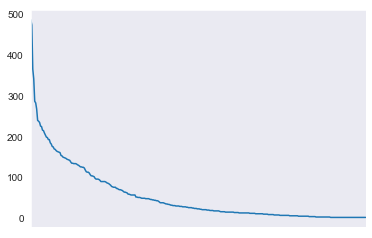

In [11]:
ax = review_count_by_reviewer.sort_values(ascending=False).plot()
ax.get_xaxis().set_visible(False)

In [12]:
review_count_by_reviewer.describe()

count    345.00000
mean      53.37971
std       72.40630
min        1.00000
25%        6.00000
50%       22.00000
75%       75.00000
max      486.00000
dtype: float64

## What is the median time for a reviewer to first review code?

What kinds of transactions do we have to consider?

In [13]:
df["type"].value_counts()

update             59747
inline             43072
comment            40523
status             23033
title              21010
create             18440
accept             18416
request-review     18350
close              16911
request-changes     3982
abandon             2015
reopen              1877
plan-changes         430
resign               315
commandeer           259
reclaim               38
Name: type, dtype: int64

Find the transactions where a reviewer interacted with a code review.

In [14]:
interaction_types = ("accept", "request-changes", "resign")
interactions = df[df["type"].isin(interaction_types)]
interactions = interactions.rename(
    columns={
        "authorPHID": "reviewer",
        "dateCreated": "dateReviewed",
    }
)
interactions = interactions.drop(columns=["phid"])
interactions.head()

,reviewer,dateReviewed,id,revision,type
24,PHID-USER-jnyoif5j4wqdxylynukq,2019-03-01 22:43:05+00:00,590379,PHID-DREV-6uv2hnjhp5kokw63pi3u,accept
110,PHID-USER-zjksdoou7zanosl7263u,2019-03-01 21:56:15+00:00,590189,PHID-DREV-yahzokyr7tkcvhwj474z,accept
127,PHID-USER-kde347py6oyfipxxdf7o,2019-03-01 22:17:59+00:00,590274,PHID-DREV-fcxw6dsmjal2pcsa2nah,accept
146,PHID-USER-dy4zkt27g2wyaqmdj4yb,2019-03-01 22:13:15+00:00,590268,PHID-DREV-yryfacddugemwa6q27em,accept
186,PHID-USER-hkitahbkppitqpq54yj3,2019-03-01 21:53:55+00:00,590148,PHID-DREV-mklrrpygu57j3vkc5nmg,accept


In [15]:
print("Total times reviewers interacted with code reviews:", len(interactions))

Total times reviewers interacted with code reviews: 22713


We only want to measure the time a review spent in the "Needs Review" state.  That state could be interrupted by (potentially long) periods of the review sitting in the "Planned Changes" state.  To simplify the calculation of the time spent waiting for review we can exlude all reviews that spent time in "Planned Changes".

In [16]:
changes_planned = df[df["type"] == "plan-changes"]
print("Reviews with changes planned:", changes_planned["revision"].nunique())

Reviews with changes planned: 350


In [17]:
changes_planned_rev_array = changes_planned["revision"].unique()

Dump the "Planned Changes" transactions.

In [18]:
interactions = interactions.set_index("revision").drop(changes_planned_rev_array, errors="ignore")

Sort all of the interactions by date.  Then Group all interactions by reviewer and then by revision, creating (reviewer, revision) pairs for each interaction.

In [19]:
grouped_interactions = interactions.sort_values(by="dateReviewed").groupby(["reviewer", "revision"], sort=False)

In [20]:
grouped_interactions.head().head()

,reviewer,dateReviewed,id,type
revision,,,,
PHID-DREV-jqheldrf42ofmcyifequ,PHID-USER-goay3vnqs5ldxywsyhgx,2017-09-19 08:36:30+00:00,1259,accept
PHID-DREV-nzvfd4l56oze55mp6xxb,PHID-USER-l4frlm5ami3cecyifazx,2017-10-03 21:01:26+00:00,1976,accept
PHID-DREV-nzvfd4l56oze55mp6xxb,PHID-USER-l4frlm5ami3cecyifazx,2017-10-04 20:34:08+00:00,2092,accept
PHID-DREV-7nzb74ztgndxfaixdal6,PHID-USER-yeffbpgn7yuxf5lcd3pe,2017-10-10 20:16:29+00:00,2424,accept
PHID-DREV-45rk7gdsel2xfflh6hys,PHID-USER-ciaomkrkqpbwfmdqahdu,2017-10-11 07:37:59+00:00,2470,accept


We can verify that we have all of the interactions a reviewer had with a review grouped and sorted by interaction date.

In [21]:
grouped_interactions.get_group(("PHID-USER-bc7buyjofiulmsokmvj3", "PHID-DREV-6f2j4scabjtbmgrpdikq"))

,reviewer,dateReviewed,id,type
revision,,,,
PHID-DREV-6f2j4scabjtbmgrpdikq,PHID-USER-bc7buyjofiulmsokmvj3,2017-10-17 18:32:14+00:00,2984,request-changes
PHID-DREV-6f2j4scabjtbmgrpdikq,PHID-USER-bc7buyjofiulmsokmvj3,2017-10-17 18:41:54+00:00,2989,accept
PHID-DREV-6f2j4scabjtbmgrpdikq,PHID-USER-bc7buyjofiulmsokmvj3,2017-10-18 13:59:17+00:00,3120,accept


Keep just the first interaction from each (reviewer, review) interaction pair, which corresponds to the first time the reviewer X worked with revision Y.

In [22]:
first_review = grouped_interactions.first()
first_review.head()

,,dateReviewed,id,type
reviewer,revision,,,
PHID-USER-goay3vnqs5ldxywsyhgx,PHID-DREV-jqheldrf42ofmcyifequ,2017-09-19 08:36:30+00:00,1259,accept
PHID-USER-l4frlm5ami3cecyifazx,PHID-DREV-nzvfd4l56oze55mp6xxb,2017-10-03 21:01:26+00:00,1976,accept
PHID-USER-yeffbpgn7yuxf5lcd3pe,PHID-DREV-7nzb74ztgndxfaixdal6,2017-10-10 20:16:29+00:00,2424,accept
PHID-USER-ciaomkrkqpbwfmdqahdu,PHID-DREV-45rk7gdsel2xfflh6hys,2017-10-11 07:37:59+00:00,2470,accept
PHID-USER-ppexvnh4ahku2ypgjpmd,PHID-DREV-qo6b3j3wrruxlqsmusyk,2017-10-11 08:15:41+00:00,2474,accept


We can see that only the first interaction per-review was selected for a given reviewer.

In [23]:
first_review.loc["PHID-USER-bc7buyjofiulmsokmvj3"].head()

,dateReviewed,id,type
revision,,,
PHID-DREV-23t4txjuupbq2pmavbcb,2017-10-16 22:39:51+00:00,2844,accept
PHID-DREV-yxbfrdfwxp6oq3yjjncl,2017-10-16 22:40:58+00:00,2846,accept
PHID-DREV-4c62atqhi4c4cmtk4acz,2017-10-17 14:37:39+00:00,2909,accept
PHID-DREV-6f2j4scabjtbmgrpdikq,2017-10-17 18:32:14+00:00,2984,request-changes
PHID-DREV-ilvj3v4dfoff3hfpj5sp,2017-10-20 16:21:06+00:00,3369,accept


Merge in the time that the revisions were first created.

In [24]:
opens = df[df["type"] == "create"][["revision", "dateCreated"]].rename(
    columns={"dateCreated": "dateRevisionCreated"}
)
reviews = pd.merge(first_review.reset_index(), opens, on="revision")
reviews.shape

(17977, 6)

In [25]:
reviews.head()

,reviewer,revision,dateReviewed,id,type,dateRevisionCreated
0,PHID-USER-goay3vnqs5ldxywsyhgx,PHID-DREV-jqheldrf42ofmcyifequ,2017-09-19 08:36:30+00:00,1259,accept,2017-09-19 04:45:09+00:00
1,PHID-USER-l4frlm5ami3cecyifazx,PHID-DREV-nzvfd4l56oze55mp6xxb,2017-10-03 21:01:26+00:00,1976,accept,2017-10-03 20:23:08+00:00
2,PHID-USER-yeffbpgn7yuxf5lcd3pe,PHID-DREV-7nzb74ztgndxfaixdal6,2017-10-10 20:16:29+00:00,2424,accept,2017-10-10 18:54:31+00:00
3,PHID-USER-ciaomkrkqpbwfmdqahdu,PHID-DREV-45rk7gdsel2xfflh6hys,2017-10-11 07:37:59+00:00,2470,accept,2017-10-10 17:09:46+00:00
4,PHID-USER-ppexvnh4ahku2ypgjpmd,PHID-DREV-qo6b3j3wrruxlqsmusyk,2017-10-11 08:15:41+00:00,2474,accept,2017-10-10 21:34:40+00:00


When calculating the time from revision creation until a review is performed we want to calculate *business days*, not calendar days.  If we don't do this then reviews that cross weekends could skew the results.

In [26]:
from businessdays import bday_duration

reviews["review_duration"] = reviews.apply(
    lambda x: bday_duration(x["dateRevisionCreated"], x["dateReviewed"]),
    axis="columns",
)
reviews.head()

,reviewer,revision,dateReviewed,id,type,dateRevisionCreated,review_duration
0,PHID-USER-goay3vnqs5ldxywsyhgx,PHID-DREV-jqheldrf42ofmcyifequ,2017-09-19 08:36:30+00:00,1259,accept,2017-09-19 04:45:09+00:00,03:51:21
1,PHID-USER-l4frlm5ami3cecyifazx,PHID-DREV-nzvfd4l56oze55mp6xxb,2017-10-03 21:01:26+00:00,1976,accept,2017-10-03 20:23:08+00:00,00:38:18
2,PHID-USER-yeffbpgn7yuxf5lcd3pe,PHID-DREV-7nzb74ztgndxfaixdal6,2017-10-10 20:16:29+00:00,2424,accept,2017-10-10 18:54:31+00:00,01:21:58
3,PHID-USER-ciaomkrkqpbwfmdqahdu,PHID-DREV-45rk7gdsel2xfflh6hys,2017-10-11 07:37:59+00:00,2470,accept,2017-10-10 17:09:46+00:00,14:28:13
4,PHID-USER-ppexvnh4ahku2ypgjpmd,PHID-DREV-qo6b3j3wrruxlqsmusyk,2017-10-11 08:15:41+00:00,2474,accept,2017-10-10 21:34:40+00:00,10:41:01


Group by reviewer and find the median time to review.

In [27]:
hours_to_review = reviews.set_index("reviewer")["review_duration"].dt.total_seconds() / 3600
grouped_reviews = hours_to_review.groupby("reviewer")
reviewer_stats = pd.DataFrame({"median_hours_to_review": grouped_reviews.median(), "review_count": grouped_reviews.size()})
reviewer_stats.sort_values("review_count", ascending=False).head(50).reset_index(drop=True)

,median_hours_to_review,review_count
0,14.199444,493
1,12.043611,457
2,13.271389,347
3,15.836944,331
4,12.716111,287
5,9.837500,277
6,2.798611,275
7,27.797083,230
8,21.155278,223
9,17.702500,223


Merge in the real usernames and save the final output to a .csv file.

In [28]:
report = reviewer_stats.join(users_df.set_index("phid")[["realName", "username"]])
report = report.rename(
    columns={
        "realName": "real_name",
        "username": "phabricator_user",
    }
)
report = report.sort_values("review_count", ascending=False).reset_index(drop=True)
outfile = datapath / "median-review-times.csv"
report.to_csv(outfile)